In [13]:
import csv
ori_file_path = './benchmark_results.csv'
ori_models_list = ["784_56_10", "196_25_10", "196_24_14_10", "28_6_16_10_5", "14_5_11_80_10_3"]

## Prepare

In [14]:
def read_data_for_architectures(file_path, target_architectures):
    # Ensure target_architectures is a list for uniform processing
    if isinstance(target_architectures, str):
        target_architectures = [target_architectures]

    results = {arch: {} for arch in target_architectures}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            framework = row['Framework']
            #frameworks.append(framework)
            architecture = row['Architecture']
            
            for target_arch in target_architectures:
                if architecture.lower() == target_arch.lower():
                    # This line ensures the last matching entry for each framework is kept
                    results[target_arch][framework] = [
                        row['Accuracy Loss (%)'],
                        row['Avg Memory Usage (MB)'],
                        row['Std Memory Usage'],
                        row['Avg Proving Time (s)'],
                        row['Std Proving Time']
                    ]
    
    return results


In [15]:
def target_arch(model_name):
    layers = model_name.split("_")
    if int(layers[0]) < 30:
        arch = "Input-Conv2d-Conv2d" + (len(layers)-4) * "-Dense" + "_Kernal"
        layers[0] = str(int(layers[0])**2)
        target = f'{arch} ({"x".join(layers[:-1])}_{layers[-1]}x{layers[-1]})'
    else:
        layers = model_name.split("_")
        arch = "Input" + (len(layers)-1) * "-Dense"
        target = f'{arch} ({"x".join(layers)})'
    
    return target

### Combine benchmark results

In [16]:
import pandas as pd

def read_and_combine_data(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    #print ('Header:', df.head())

    # Group data by Framework and Architecture for processing
    grouped = df.groupby(['Framework', 'Architecture'])
    #print (grouped)
    
    for (framework, architecture), group in grouped:
        if len(group) == 2:  # Expecting two entries per group for combination
            base = group.iloc[0]
            follow_up = group.iloc[1]
            
            # Ensure we start with the base and follow up in the correct order
            if "start from 1000" in str(follow_up['Notes']):
                base, follow_up = follow_up, base  # Swap if in wrong order
            
            combined = base.copy()
            n1, n2 = 1000, 1500
            combined['Testing Size'] = 2500
            
            # Combine the metrics
            for metric in ['Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)']:
                combined[metric] = (n1 * base[metric] + n2 * follow_up[metric]) / (n1 + n2)
                
            for metric in ['Std Memory Usage', 'Std Proving Time']:
                # Placeholder for standard deviation combination, here we simply copy from follow_up
                # In reality, you should calculate combined standard deviation using a proper statistical method
                combined[metric] = follow_up[metric]
                

            combined['Notes'] = "Combined 0-2500"
            combined = combined.to_dict()
            for key in combined:
                combined[key] = [combined[key]]

            new_row_df = pd.DataFrame(combined)
            df = pd.concat([df, new_row_df], ignore_index=True)

    df.to_csv(file_path, index=False)

## Analysis

In [58]:
def extract(data, architectures):
    frameworks = list(data[architectures[0]].keys())

    memory_usage = {arch: [] for arch in architectures}
    accuracy_loss = {arch: [] for arch in architectures}
    proving_time = {arch: [] for arch in architectures}

    # Iterate over the original data to populate the new structures
    for arch, fw_data in data.items():
        for fw in frameworks:
            # Append memory usage and proving time to the respective dictionaries
            # Convert string values to float for numerical processing
            accuracy_loss[arch].append(float(fw_data[fw][0]))
            memory_usage[arch].append(float(fw_data[fw][1]))
            proving_time[arch].append(float(fw_data[fw][3]))

    return frameworks, accuracy_loss, memory_usage, proving_time

def normalize(data):
    """Normalize the data so that lower values result in higher normalized scores.
    A lower original value results in a normalized value closer to 1."""
    min_val = min(data)
    max_val = max(data)
    # Invert the normalization: The best (lowest) value gets a score of 1, and the worst (highest) value gets a score of 0.
    return [(max_val - x) / (max_val - min_val) if max_val - min_val else 1 for x in data]


In [129]:
import matplotlib.pyplot as plt
import numpy as np
def plot_bar(archs, frameworks, accuracy_loss, memory_usage, proving_time):
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))  # Adjusted for 3 subplots

    # Plotting Accuracy Loss
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[0].bar(indices + i*0.3, accuracy_loss[arch], width=0.3, label=arch)

    ax[0].set_title('Accuracy Loss (%)')
    ax[0].set_xticks(indices + 0.3 / 2)
    ax[0].set_xticklabels(frameworks)
    ax[0].legend(title="Architecture")
    ax[0].set_ylabel('Accuracy Loss (%)')

    # Plotting Memory Usage
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[1].bar(indices + i*0.3, memory_usage[arch], width=0.3, label=arch)

    ax[1].set_title('Average Memory Usage (MB)')
    ax[1].set_xticks(indices + 0.3 / 2)
    ax[1].set_xticklabels(frameworks)
    ax[1].legend(title="Architecture")
    ax[1].set_ylabel('Memory Usage (MB)')

    # Plotting Proving Time
    for i, arch in enumerate(archs):
        indices = np.arange(len(frameworks))
        ax[2].bar(indices + i*0.3, proving_time[arch], width=0.3, label=arch)

    ax[2].set_title('Average Proving Time (s)')
    ax[2].set_xticks(indices + 0.3 / 2)
    ax[2].set_xticklabels(frameworks)
    ax[2].legend(title="Architecture")
    ax[2].set_ylabel('Proving Time (s)')

    plt.tight_layout()
    plt.show()


In [135]:
def prepare_spider_data(archs, frameworks, accuracy_loss, memory_usage, proving_time):
    # Normalize the data
    normalized_memory_usage = {arch: normalize(values) for arch, values in memory_usage.items()}
    normalized_proving_time = {arch: normalize(values) for arch, values in proving_time.items()}
    normalized_accuracy_loss = {arch: normalize(values) for arch, values in accuracy_loss.items()}
    
    # Prepare the transition data and calculate sums
    transition_data = {}
    sums_per_arch = {arch: {} for arch in archs}  # Stores the sum of scores for each framework per architecture

    for fw in frameworks:
        transition_data[fw] = []
        for arch in archs:
            # Extract the normalized scores for the current framework and architecture
            accu_score = normalized_accuracy_loss[arch][frameworks.index(fw)]
            mem_score = normalized_memory_usage[arch][frameworks.index(fw)]
            time_score = normalized_proving_time[arch][frameworks.index(fw)]
            
            # Append the 3-dimensional vector
            transition_data[fw].append((accu_score, mem_score, time_score))
            
            # Calculate the sum of normalized scores
            sum_scores = accu_score + mem_score + time_score
            sums_per_arch[arch][fw] = sum_scores

    # Rank frameworks for each architecture based on the sum of scores
    ranks_per_arch = {}
    for arch in archs:
        # Sort frameworks based on sum of scores, higher is better
        ranked_frameworks = sorted(sums_per_arch[arch].items(), key=lambda x: x[1], reverse=True)
        ranks_per_arch[arch] = ranked_frameworks

    # Output the transition vectors and sum of scores for each framework, and their ranks
    # for fw, vectors in transition_data.items():
    #     print(f"{fw} transitions:")
    #     for i, arch in enumerate(archs):
    #         print(f"  {arch}: {vectors[i]}, Sum of scores: {sums_per_arch[arch][fw]}")
    #     print()

    # Output ranks for each architecture
    for arch, ranks in ranks_per_arch.items():
        print(f"Ranking for {arch}:")
        for rank, (fw, score) in enumerate(ranks, start=1):
            print(f"  {rank}. {fw} with a score of {score}")
        print()

    return transition_data


In [154]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
def plot_spider_trans(archs, transition_data):
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Prepare the plot
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Create a figure
    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2, subplot_kw=dict(polar=True))
    axs = axs.flatten()  # Flatten to easily iterate over

    # Assuming 'transition_data', 'metrics', 'archs' are defined as before

    for ax, (fw, vectors) in zip(axs, transition_data.items()):
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # Draw one axe per variable + add labels if needed
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        
        # Plot each transition for the framework, without adding a legend here
        for i, vector in enumerate(vectors):
            data = np.array(vector + vector[:1])  # Repeat the first value at the end to close the loop
            ax.plot(angles, data, 'o-', linewidth=2)
            ax.fill(angles, data, alpha=0.25)
        
        ax.set_title(fw)

    # Create custom legend entries
    legend_elements = [mlines.Line2D([], [], color='blue', marker='o', linestyle='-', linewidth=2, label=archs[0]),
                    mlines.Line2D([], [], color='orange', marker='o', linestyle='-', linewidth=2, label=archs[1])]

    # Place a single legend outside the subplots
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()

In [159]:
a = [1,3,5,20]
a.index(3)

1

In [166]:
def plot_spider_arch(transition_data, arch, archs):
    index = archs.index(arch)
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Number of variables we're plotting
    num_vars = len(metrics)

    # Split the circle into even parts and save angles so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plot needs to be a closed circle, so we need to append the start value to the end.
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

    # Draw y-labels (optionally adjust the range based on your scores)
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)

    for fw, vectors in transition_data.items():
        values = vectors[index]
        # Radar chart plot needs to be a closed loop, so we need to append the start value to the end.
        values += values[:1]

        
        ax.plot(angles, values, label=fw)
        ax.fill(angles, values, alpha=0.1)

    plt.title(f'Framework Performance Comparison\nArchitecture: {arch}')
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))

    plt.show()


### Varing Layer in DNN

In [132]:
architectures = [target_arch(ori_models_list[1]), target_arch(ori_models_list[2])]
data = read_data_for_architectures('./dnn_layer.csv', architectures)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)


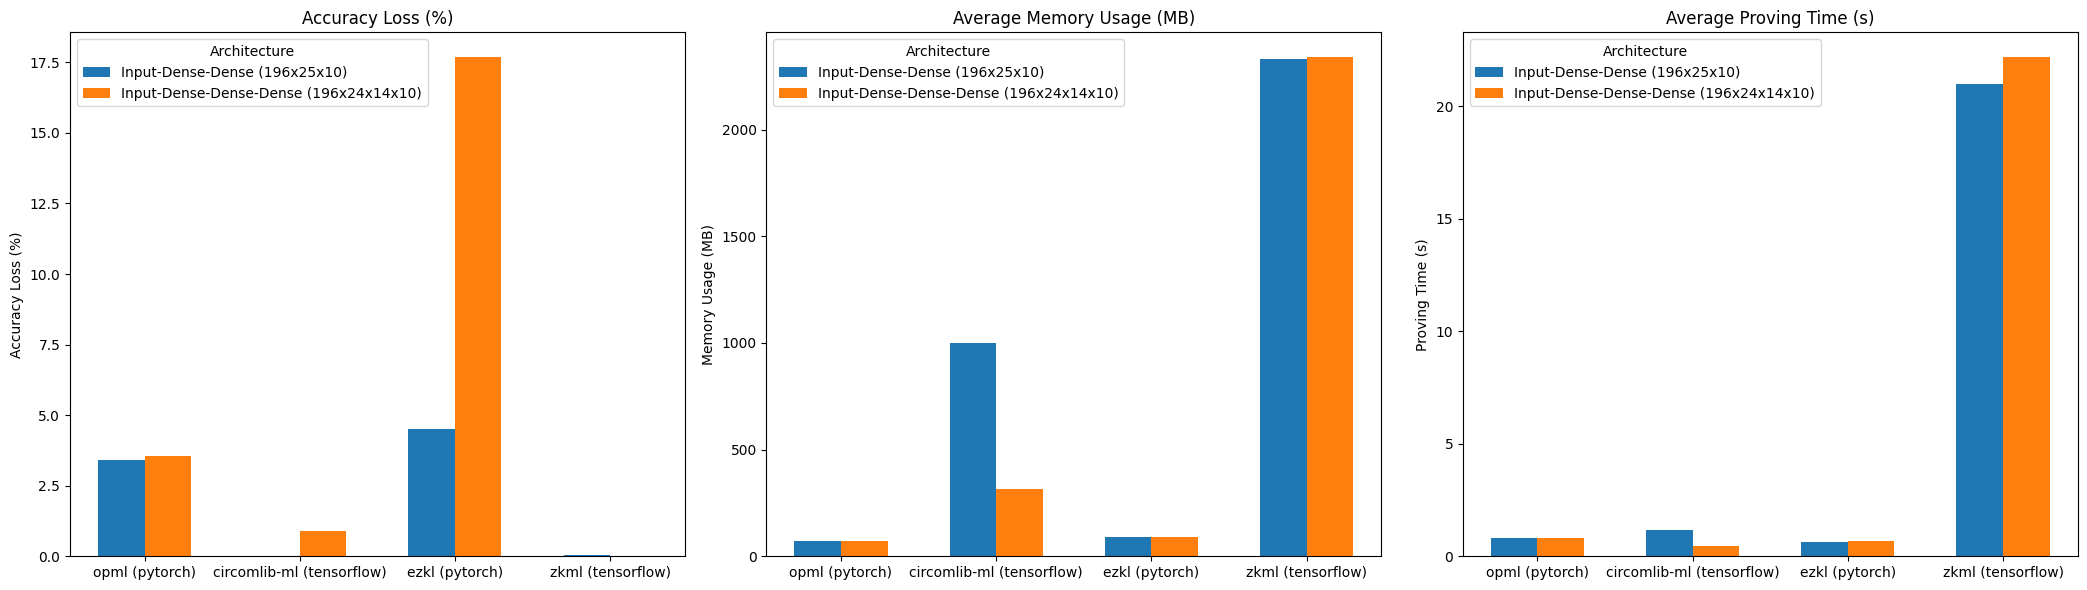

In [133]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

In [136]:
transition_data = prepare_spider_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Dense-Dense (196x25x10):
  1. circomlib-ml (tensorflow) with a score of 2.564563344918927
  2. opml (pytorch) with a score of 2.240841537509742
  3. ezkl (pytorch) with a score of 1.991617173065194
  4. zkml (tensorflow) with a score of 0.9867256637168142

Ranking for Input-Dense-Dense-Dense (196x24x14x10):
  1. circomlib-ml (tensorflow) with a score of 2.842169051662779
  2. opml (pytorch) with a score of 2.781947028741266
  3. ezkl (pytorch) with a score of 1.980167323129606
  4. zkml (tensorflow) with a score of 1.0



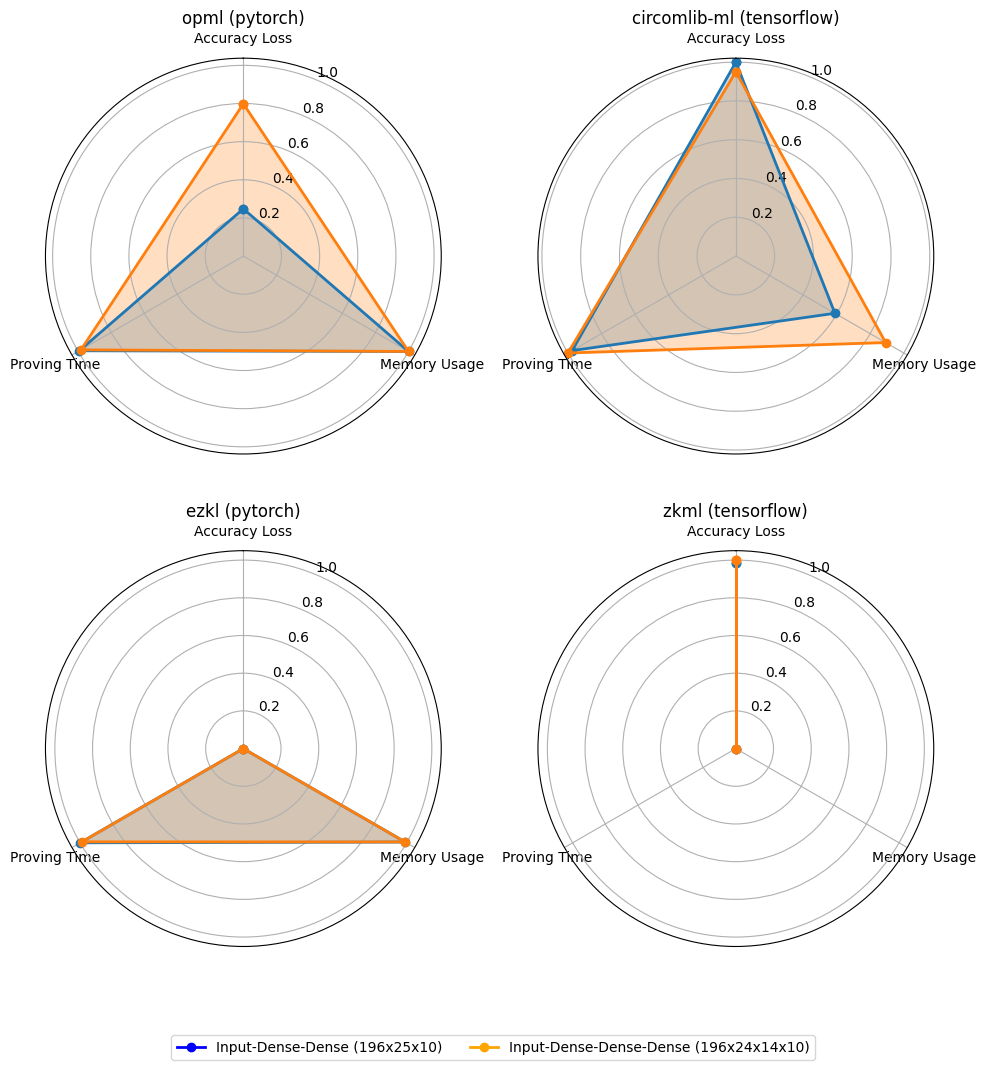

In [163]:
plot_spider_trans(architectures, transition_data)

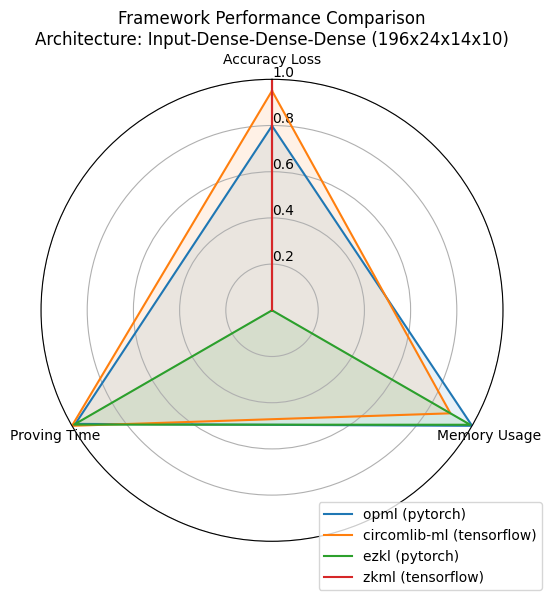

In [169]:
plot_spider_arch(transition_data, architectures[1], architectures)

### Varing Param in DNN

In [107]:
archs = [target_arch(ori_models_list[1]), target_arch(ori_models_list[2])]
archs = [target_arch(ori_models_list[1]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./dnn_param.csv', archs)
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, archs)


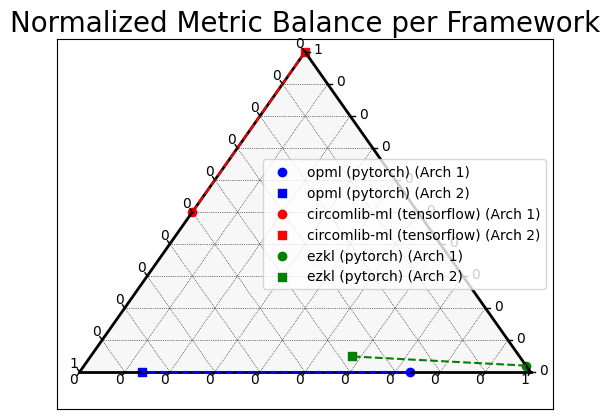

In [31]:
# Plotting
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=0.1)
tax.set_title("Normalized Metric Balance per Framework", fontsize=20)

# Define styles for different architectures
# Assuming two architectures for simplicity in matching pairs
markers = ['o', 's']  # Example: circle for the first architecture, square for the second
colors = {'opml (pytorch)': 'blue', 'circomlib-ml (tensorflow)': 'red', 'ezkl (pytorch)': 'green'}

# Plot points and transitions
for i, ((scores, fw), marker) in enumerate(zip(ternary_data, markers*len(frameworks))):
    color = colors[fw]
    label = f"{fw} (Arch {i%2+1})"
    tax.scatter([scores], marker=marker, color=color, label=label)
    
    # Draw transitions between architectures if this is the second architecture
    if i % 2 == 1:
        prev_scores, _ = ternary_data[i-1]
        tax.line(prev_scores, scores, color=color, linestyle="--")

tax.legend()
tax.ticks(axis='lbr', linewidth=1, multiple=0.1)
tax.clear_matplotlib_ticks()
ternary.plt.show()

AttributeError: 'list' object has no attribute 'items'

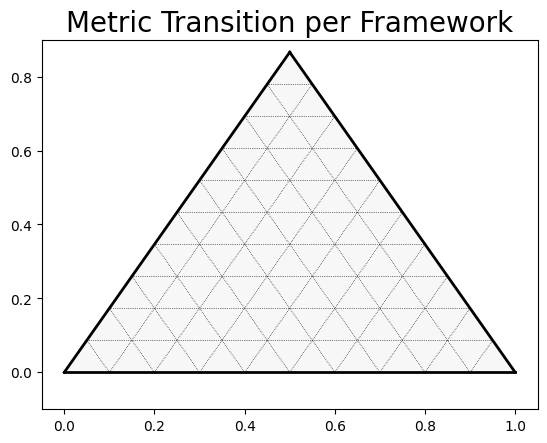

In [22]:
import ternary

# Assuming ternary_data has been prepared as before, but now we need a different approach

# Example structure for ternary_data to facilitate transitions (simplified for explanation):
# Assuming ternary_data is now a dictionary mapping framework names to their points in each architecture
# {
#     'framework_name': [('architecture_1', [normalized_scores]), ('architecture_2', [normalized_scores])]
# }

# New function or modification to prepare data in the above structure
# For simplicity, the function is not shown, but you would adjust prepare_ternary_data accordingly

# Now, plotting with transitions
figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=0.1)
tax.set_title("Metric Transition per Framework", fontsize=20)

# Assume ternary_data is prepared as described
for fw, arch_points in ternary_data.items():
    if len(arch_points) < 2:
        continue  # Skip if there aren't at least two architectures for comparison
    
    # Extract points for the two architectures
    point1, label1 = arch_points[0][1], arch_points[0][0]
    point2, label2 = arch_points[1][1], arch_points[1][0]
    
    # Plot points
    tax.scatter([point1], label=f"{fw} ({label1})", color='blue')
    tax.scatter([point2], label=f"{fw} ({label2})", color='red')
    
    # Draw line between points
    tax.line(point1, point2, color='green', linestyle="--")

tax.legend()
tax.ticks(axis='lbr', linewidth=1, multiple=0.1)
tax.clear_matplotlib_ticks()

ternary.plt.show()


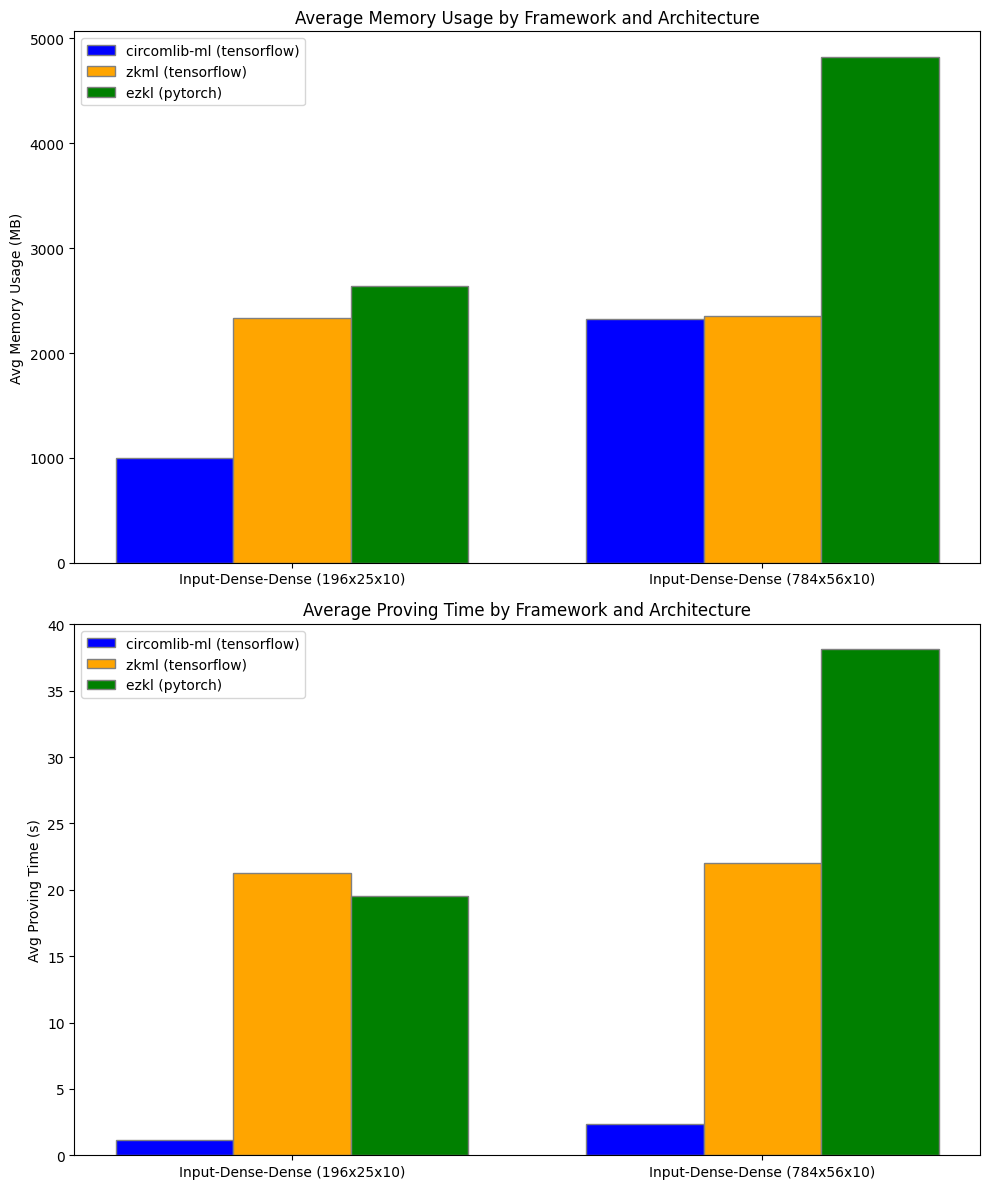

In [ ]:
# Required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

# Data setup
frameworks = ['circomlib-ml (tensorflow)', 'zkml (tensorflow)', 'ezkl (pytorch)']
architectures = ['Input-Dense-Dense (196x25x10)', 'Input-Dense-Dense (784x56x10)']
colors = ['blue', 'orange', 'green']  # Color for each framework

# Memory Usage data (MB)
memory_usage_data = {
    'Input-Dense-Dense (196x25x10)': [998.735, 2334.296, 2636.281],  # [circomlib-ml, zkml, ezkl]
    'Input-Dense-Dense (784x56x10)': [2328.322, 2357.363, 4826.888],  # [circomlib-ml, zkml, ezkl]
}

# Proving Time data (s)
proving_time_data = {
    'Input-Dense-Dense (196x25x10)': [1.169, 21.263, 19.526],  # [circomlib-ml, zkml, ezkl]
    'Input-Dense-Dense (784x56x10)': [2.351, 22.013, 38.134],  # [circomlib-ml, zkml, ezkl]
}

fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Bar width
bar_width = 0.25
# Positions of the left bar-boundaries
r1 = np.arange(len(architectures))
# Positions of the bars for each framework
positions = [r1 + bar_width*i for i in range(len(frameworks))]

# Plot Memory Usage
for idx, fw in enumerate(frameworks):
    memory_usage = [memory_usage_data[arch][idx] for arch in architectures]
    axs[0].bar(positions[idx], memory_usage, color=colors[idx], width=bar_width, edgecolor='grey', label=fw)

axs[0].set_title('Average Memory Usage by Framework and Architecture')
axs[0].set_xticks([r + bar_width for r in range(len(architectures))])
axs[0].set_xticklabels(architectures)
axs[0].set_ylabel('Avg Memory Usage (MB)')
axs[0].legend()

# Plot Proving Time
for idx, fw in enumerate(frameworks):
    proving_time = [proving_time_data[arch][idx] for arch in architectures]
    axs[1].bar(positions[idx], proving_time, color=colors[idx], width=bar_width, edgecolor='grey', label=fw)

axs[1].set_title('Average Proving Time by Framework and Architecture')
axs[1].set_xticks([r + bar_width for r in range(len(architectures))])
axs[1].set_xticklabels(architectures)
axs[1].set_ylabel('Avg Proving Time (s)')
axs[1].legend()

plt.tight_layout()
plt.show()


### Change layers & Value lightweight

## CNN

### Best Overall

## Fix layers & Check perf diff